In [2]:
import sqlite3
import pandas as pd
import matplotlib
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    return run_query('SELECT name, type FROM sqlite_master WHERE type IN ("table", "view")')

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [34]:
usa_invoices = run_query('''SELECT
                                i.invoice_id,
                                il.track_id
                             FROM invoice i
                             INNER JOIN customer c ON c.customer_id = i.customer_id
                             INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
                             WHERE c.country = "USA"''')
usa_invoices.head(5)
                              

,invoice_id,track_id
0,1,1158
1,1,1159
2,1,1160
3,1,1161
4,1,1162


In [35]:
track_genre = run_query('''WITH
                            track_genre AS
                            (
                                SELECT 
                                    t.track_id,
                                    g.name genre
                                FROM track t
                                INNER JOIN genre g ON g.genre_id = t.genre_id
                             ),
                             USA_customers AS
                             (
                                 SELECT
                                    i.invoice_id,
                                    il.track_id
                                 FROM invoice i
                                 INNER JOIN customer c ON c.customer_id = i.customer_id
                                 INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
                                 WHERE c.country = "USA"
                              )
                            SELECT 
                                tg.genre,
                                COUNT(us.track_id) total_tracks,
                                CAST(COUNT(us.track_id) as float)/(SELECT CAST(COUNT(track_id) as float) FROM USA_customers) * 100 percentage
                            FROM track_genre tg
                            INNER JOIN USA_customers us ON tg.track_id = us.track_id
                            GROUP BY tg.genre
                            ORDER BY total_tracks DESC;''')



In [36]:
track_genre

,genre,total_tracks,percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


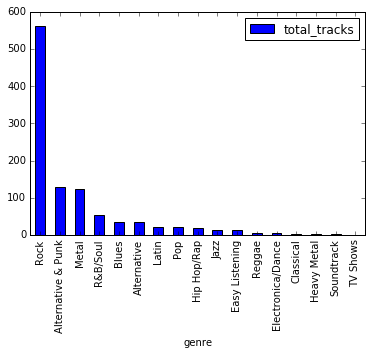

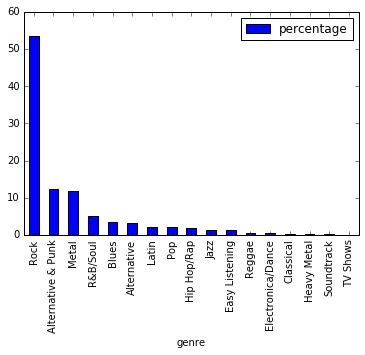

In [37]:
track_genre.plot.bar(x='genre', y='total_tracks')
track_genre.plot.bar(x='genre', y='percentage')

## Most popular genre in USA by track purchases

The table above, as well as the corresponding bar graphs illustrate the most popular music genres according to track purchases in Chinook. By far, `Rock` is the most popular genre among U.S. customers, followed by `Alternative & Punk`, `Metal`, `R&B\Soul`, and `Blues`. `Pop` music is slightly more popular than `Hip Hop\Rap`, by 0.1 percentage points. 

Given the above findings, I recommend that the artists Red Tone (`Punk`), Slim Jim Bites (`Blues`), and Meteor and the Girls (`Pop`) be added to the Chinook store to be marketed in the USA.

In [45]:
employee_total_assigned = run_query('''WITH customer_purchases AS
              (
                  SELECT
                      c.customer_id,
                      c.support_rep_id,
                      SUM(i.total) total_purchases
                  FROM customer c
                  INNER JOIN invoice i ON i.customer_id = c.customer_id
                  GROUP BY c.customer_id
               )
               
               SELECT 
                   e.last_name||', '||e.first_name employee_name,
                   e.title,
                   SUM(cp.total_purchases) total_assigned
               FROM employee e
               INNER JOIN customer_purchases cp ON cp.support_rep_id = e.employee_id
               GROUP BY employee_name
               ORDER BY total_assigned DESC;
            ''')

In [46]:
employee_total_assigned

,employee_name,title,total_assigned
0,"Peacock, Jane",Sales Support Agent,1731.51
1,"Park, Margaret",Sales Support Agent,1584.00
2,"Johnson, Steve",Sales Support Agent,1393.92


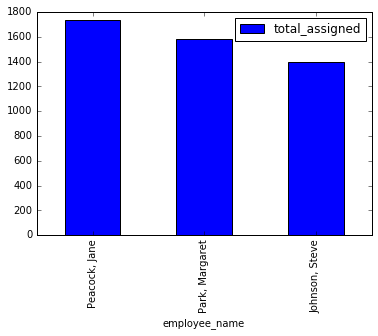

In [47]:
employee_total_assigned.plot.bar(x='employee_name', y='total_assigned')

## Top Support Staff

According to the analysis Jane Peacock is the top Sales Support Agent at Chinook, followed by Margaret Park and Steve Johnson.

In [72]:
run_query(''' WITH quant AS
              (
                  SELECT
                      CASE
                        WHEN COUNT(DISTINCT c.customer_id) = 1 THEN "Other"
                        ELSE c.country
                      END country,
                      COUNT(DISTINCT c.customer_id) total_customers,
                      SUM(i.total) total_sales,
                      SUM(i.total) / COUNT(DISTINCT i.customer_id) customer_avg_sales,
                      SUM(i.total) / COUNT(i.invoice_id) order_avg_value
                  FROM invoice i 
                  INNER JOIN customer c ON c.customer_id = i.customer_id
                  GROUP BY country
              ), consolidate_other AS
              (
                  SELECT 
                      country,
                      SUM(total_customers) total_customers,
                      SUM(total_sales) total_sales,
                      SUM(customer_avg_sales) / COUNT(customer_avg_sales) customer_avg_sales,
                      SUM(order_avg_value) / COUNT(order_avg_value) order_avg_value
                  FROM quant
                  GROUP BY country
              ), sort AS
              (
                  SELECT
                      co.*,
                      CASE
                          WHEN country = "Other" THEN 1
                          ELSE 0
                      END sort
                  FROM consolidate_other co
              )
              
              SELECT 
                  country,
                  total_customers,
                  total_sales,
                  customer_avg_sales,
                  order_avg_value
              FROM sort
              ORDER BY sort, total_sales DESC;''')



,country,total_customers,total_sales,customer_avg_sales,order_avg_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


In [73]:
country_description = run_query(''' WITH quant AS
              (
                  SELECT
                      CASE
                        WHEN COUNT(DISTINCT c.customer_id) = 1 THEN "Other"
                        ELSE c.country
                      END country,
                      COUNT(DISTINCT c.customer_id) total_customers,
                      SUM(i.total) total_sales,
                      SUM(i.total) / COUNT(DISTINCT i.customer_id) customer_avg_sales,
                      SUM(i.total) / COUNT(i.invoice_id) order_avg_value
                  FROM invoice i 
                  INNER JOIN customer c ON c.customer_id = i.customer_id
                  GROUP BY country
              ), consolidate_other AS
              (
                  SELECT 
                      country,
                      SUM(total_customers) total_customers,
                      SUM(total_sales) total_sales,
                      SUM(customer_avg_sales) / COUNT(customer_avg_sales) customer_avg_sales,
                      SUM(order_avg_value) / COUNT(order_avg_value) order_avg_value
                  FROM quant
                  GROUP BY country
              ), sort AS
              (
                  SELECT
                      co.*,
                      CASE
                          WHEN country = "Other" THEN 1
                          ELSE 0
                      END sort
                  FROM consolidate_other co
              )
              
              SELECT 
                  country,
                  total_customers,
                  total_sales,
                  customer_avg_sales,
                  order_avg_value
              FROM sort
              ORDER BY sort, total_sales DESC;''')



## Update on where we are in this lesson

Finally finished that unholy query. Though, honestly, I hope we learned a lesson. We basically thought of that solution hours ago, but were so convinced that there had to be another way to do it that we refused to implement it. Next time, implement the damn plan. 

#### Part 6
Is all visualization so we're skipping it and getting right into Part 7 (current page) which I believe is going to be about `SET OPERATIONS`. Yay SQL.

## Solutions

I had a hard time with this one. In fact, I had to turn to other solutions to see how people had completed this one. Here are the three ways:

- *Q&A Solution*
    - This solution does not use the `EXCEPT` operation recommended by DataQuest, but rather seems to look for instances where `invoice_id` occurred once after grouping by `invoice_id` and `album_id`. The double grouping allowed invoices with multiple albums to show up in multiple lines, opposed to grouping only by `invoice_id` which would have consolidated the data into one line per `invoice_id`. 
    - One note, this is not the exact query the other user utilized. Instead I'm writing my query based on their reasoning. 

In [14]:
run_query(''' WITH
             invoice_tracks AS
             (
                SELECT 
                    i.invoice_id,
                    i.track_id,
                    t.album_id
                FROM invoice_line i
                INNER JOIN track t ON t.track_id = i.track_id
                GROUP BY 1, 3
             ), sort_purchase_type AS
             (
                SELECT 
                    i.invoice_id,
                    CASE
                        WHEN COUNT(i.invoice_id) = 1 THEN 1
                        ELSE 0
                    END album_purchase
                FROM invoice_tracks i
                GROUP BY invoice_id
                 )
            SELECT 
                COUNT(invoice_id) total_album_purchases,
                CAST(COUNT(invoice_id) as float) / 
                CAST((SELECT COUNT(DISTINCT invoice_id)
                      FROM invoice_tracks) as float) * 100 album_purchase_percentage 
                FROM sort_purchase_type
                WHERE album_purchase = 1
             ;''')


,total_album_purchases,album_purchase_percentage
0,171,27.850163


So that is the answer you get with that query. The only problem is that it is significantly off the DataQuest solution (higher by 10 percentage points!). 

My guess is that there are some invoices that only consist of songs from one album, but do not consititute an album purchase because the customer only bought a few of the songs instead of all of them. That would explain why this method gets such as higher percentage of album purchases.

I doubled-checked the code submitted by the user in the Q&A forum and they got the same answer I did above^^. 

Next up, the DataQuest solution which can be found [here](https://github.com/dataquestio/solutions/blob/master/Mission191Solutions.ipynb). 

In [17]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


## Solutions

- *DataQuest*:
    - Technically, this is __the__ solution since the the first "solution" turned out to be false. 
    - DataQuest used the `EXCEPT` set operation as they suggested in the instructions, but it was used as a subquery in a `FROM` clause to create a table upon which to draw the final solution.
    - Additionally, the key here was the subquery that created a table that contained only the `invoice_id` and the `first_track_id` queried above using the `MIN()` method. This allowed the `EXCEPT` section of the to work on the correct sections of the larger table by utilizing `WHERE` clauses to indicate which tracks to compare.  
    - In the solutions notebook, Dataquest did not recommend switching up their purchasing strategy as they would potentially lose about a fifth of revenue.

Last, but not least (well, probably least as this is a SQL course), the way I wanted to handle this problem:

In [ ]:
run_query('''SELECT
                i.invoice_id,
                i.track_id,
                t.album_id
             FROM invoice_line i
             INNER JOIN track t ON i.track_id = t.track_id
             LIMIT 10;''')